In [1]:
import os
import pandas as pd
import numpy as np
import math
import gensim
import random
from itertools import chain
import torch
import dgl
import dgl.function as fn
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report,f1_score,accuracy_score,recall_score,precision_score
from gensim.models import KeyedVectors
import re
from itertools import combinations
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pickle
from tokenizers import  BertWordPieceTokenizer
from transformers import BertTokenizer,BertModel

Using backend: pytorch


In [2]:
labels = 3
max_length =  38 #38
pixel = 49
batch_size = 16
embed_size = 300
DEVICE = 'cuda:0'
windows = 2
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [3]:
print('BERT_MIGNN_twitter26k')

BERT_MIGNN_twitter26k


In [4]:
from itertools import combinations
def get_batch_graph(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len)
        # A couple edges one-by-one
        for j in range(windows,max_len+1):
            t = range(j-windows,j)
            edges = np.array(list(combinations(t,2)))
            for edge in edges:
                g.add_edges(edge[0],edge[1])
                g.add_edge(edge[1], edge[0])
#         g.add_edge(max_length -1, 0)

        batch_graph.append(g)
    return batch_graph

def get_fusion_batch(batch_size,max_len,windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len + pixel)

        # text with pixel
        for j in range(max_length,max_length + pixel):
            for i in range(0,max_length):
                g.add_edges(i,j)
                g.add_edge(j, i)
        
        batch_graph.append(g)
        
    return batch_graph
    
batch_graph = get_batch_graph(batch_size,max_length,windows)
batch_fusion_graph = get_fusion_batch(batch_size,max_length,windows)

def get_next_batch(batch_size,batch_graph = batch_graph):
    batch_graph = batch_graph[0:batch_size]
    bg = dgl.batch(batch_graph, edge_attrs=None)
    bg = bg.to(torch.device(DEVICE))
    return bg


/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


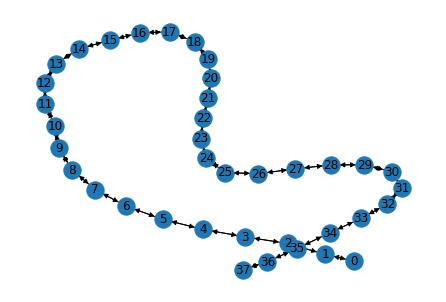

In [5]:

import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


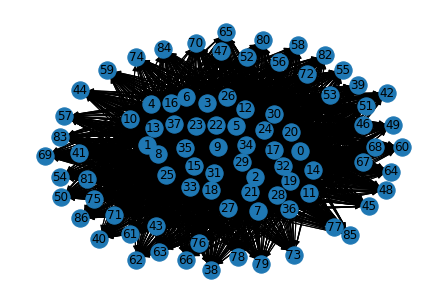

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
g_nx = batch_fusion_graph[0]
nx.draw(g_nx.to_networkx(), with_labels=True)
plt.show()


#### 数据读取

In [7]:
train_image = torch.load('./dataset/twitter26k/train_images.pkl')
train_y = torch.load('./dataset/twitter26k/train_y.pkl')
train_text = torch.load('./dataset/twitter26k/train_text.pkl')

val_image = torch.load('./dataset/twitter26k/val_images.pkl')
val_y = torch.load('./dataset/twitter26k/val_y.pkl')
val_text = torch.load('./dataset/twitter26k/val_text.pkl')

test_image = torch.load('./dataset/twitter26k/test_images.pkl')
test_y = torch.load('./dataset/twitter26k/test_y.pkl')
test_text = torch.load('./dataset/twitter26k/test_text.pkl')



In [8]:
print(train_image.shape)
print(val_image.shape)
print(test_image.shape)

torch.Size([21560, 3, 224, 224])
torch.Size([2696, 3, 224, 224])
torch.Size([2695, 3, 224, 224])


#### 数据预处理

In [9]:
pad = np.array([102] * max_length)


def get_token(texts):
    texts_tmp = []

    for t  in texts:
        token = tokenizer(t,return_tensors = 'pt')['input_ids'].numpy()[0]
        if len(token)>= max_length:
            token = token[0:max_length]
        else:
            token = np.concatenate((token,pad[0:max_length-len(token)])) 
        token = np.reshape(token,(1,-1))
        if len(texts_tmp)==0:
            texts_tmp = token
        else:
            texts_tmp = np.vstack((texts_tmp,token))
    x_texts = texts_tmp    
    
    return x_texts

train_text = get_token(train_text)
val_text = get_token(val_text)
test_text = get_token(test_text)


#### 构建数据集

In [10]:
train_set = data.TensorDataset(torch.LongTensor(train_text),torch.FloatTensor(train_image) ,torch.LongTensor(train_y))
val_set = data.TensorDataset(torch.LongTensor(val_text),torch.FloatTensor(val_image), torch.LongTensor(val_y))
test_set = data.TensorDataset(torch.LongTensor(test_text),torch.FloatTensor(test_image), torch.LongTensor(test_y))

train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size,
                                        shuffle=False)
test_data_loader = data.DataLoader(test_set, batch_size=batch_size,
                                        shuffle=False)


In [11]:


class GAT(nn.Module):
    def __init__(self, input_dim,output_dim, activation):
        super(GAT, self).__init__()
       
        self.norm = nn.BatchNorm1d(input_dim)
        self.merge_linner =  nn.Linear( input_dim , output_dim)
        self.activation = activation
        self.fc = nn.Linear(input_dim, input_dim, bias=False)
        self.attn_fc = nn.Linear(2 * input_dim, 1, bias=False)
    
    def edge_attention(self, edges):

        z2 = torch.cat([edges.src['h'], edges.dst['h']], dim=1)
        a = self.attn_fc(z2)
        return { 'e': F.leaky_relu(a)}
    
    def message_func(self, edges):
        return {'h': edges.src['h'], 'e': edges.data['e']}
    
    def reduce_func(self, nodes):

        alpha = F.softmax(nodes.mailbox['e'], dim=1)  
        h_ = nodes.data['h']
        h = torch.sum(alpha * nodes.mailbox['h'], dim=1)
        h = 0.9 * h + 0.1 * h_
        h = self.merge_linner(h)
        h = self.activation(h)
        
        return {'h': h}
    
    def forward(self, bg, h):
        h = self.fc(h)
        bg.ndata['h'] = h
        bg.apply_edges(self.edge_attention)
        bg.update_all(self.message_func, self.reduce_func)
        
        return bg.ndata.pop('h')
    
    
class SelfAttention(nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs


class Classifier(nn.Module):
    def __init__(self, labels,hidden_size = 768,drop_rate = 0.4):
        super(Classifier, self).__init__()
        self.labels = labels

        self.dropout2 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.4)
        self.dropout5 = nn.Dropout(drop_rate)
        self.dropout6 = nn.Dropout(0.6)
        self.hidden_size = hidden_size
        self.bert_model = BertModel.from_pretrained('bert-base-uncased',return_dict = True)
        self.text_normal = nn.LayerNorm((max_length,self.hidden_size))
        self.image_normal = nn.LayerNorm((pixel,self.hidden_size))
        
        self.embed_size = embed_size
        self.GAT = GAT(self.hidden_size, self.hidden_size, F.relu)
        self.att = SelfAttention(self.hidden_size)
        self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.image_trans = nn.Linear(1280, self.hidden_size)

        self.classify_h = nn.Linear(self.hidden_size , self.hidden_size)
        self.classify = nn.Linear(self.hidden_size, labels)

    def forward(self,text,image):
        
        bs = text.shape[0]
        bg = get_next_batch(bs)
        bg_fusion = get_next_batch(bs,batch_graph = batch_fusion_graph)

        text = self.bert_model(text).last_hidden_state
        text = self.text_normal(text)
        
        img = self.image_model.extract_features(image) #[bs,1280,7,7]  1280
        img = torch.reshape(img,(bs,1280,49))   #[bs,1280,49]
        img = torch.transpose(img,1,2)          #[bs,49,1280]
        img =  torch.reshape(img,(-1,1280))     #[bs*49,1280]
        img = self.image_trans(img)             #[bs*49,hidden_size]
        img = torch.reshape(img,(bs,-1,self.hidden_size))   #[bs,49,hidden_size]


        feature = torch.cat([text, img], 1)
        feature_short = torch.reshape(feature,(-1,feature.shape[2]))

        gat_feature = self.GAT(bg_fusion, feature_short)

        feature = feature_short + gat_feature
        feature = torch.reshape(feature,(bs,-1,feature.shape[-1]))
        feature = self.att(feature)

        feature = self.dropout5(feature)
        
        feature = self.classify_h(feature)
        feature = F.relu(feature)
        
        return self.classify(feature)
    

In [12]:
def model_test(data_loader,model):
    '''
    Evaluate model
    '''
    pred_Y = []
    test_Y = []

    for step,(b_texts,b_images, test_y_batch) in enumerate(data_loader):

        test_y_batch = test_y_batch.numpy()
        b_texts = b_texts.to(torch.device(DEVICE))
        b_images = b_images.to(torch.device(DEVICE))
        
        
        test_net_out = model(b_texts,b_images)

        test_net_out = test_net_out.cpu().data.numpy()
        pred_y_batch = np.argmax(test_net_out,axis = 1)
        pred_Y = np.concatenate((pred_Y,pred_y_batch), axis=0) 
        test_Y = np.concatenate((test_Y,test_y_batch), axis=0)
#     print(classification_report(test_Y,pred_Y,digits = 5))
    f1 = f1_score(test_Y,pred_Y,average='weighted')
    acc = accuracy_score(test_Y,pred_Y)
    return f1,acc



In [13]:

#build model 
net = Classifier( labels = labels)

net.to(torch.device(DEVICE))

image_model_params = list(map(id, net.image_model.parameters()))
base_params = filter(lambda p: id(p) not in image_model_params,
                     net.parameters())

optimizer = torch.optim.Adam(params = net.parameters(),
                             lr = 2e-5)


loss_func = nn.CrossEntropyLoss()


max_score = 0
# training and testing
for epoch in range(5):
    net.train()
    for step, (b_texts,b_images, b_y) in enumerate(train_data_loader):        # gives batch data
        b_texts = b_texts.to(torch.device(DEVICE))
        b_images = b_images.to(torch.device(DEVICE))
        b_y = b_y.to(torch.device(DEVICE))



        out = net(b_texts,b_images)                               # rnn output
        loss = loss_func(out, b_y) 

        if step %100 ==0:
            print('epoch:%d, step:%d, loss:%.2f'%(epoch,step,loss.cpu().data.numpy()))
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

    net.eval()
    f1,acc = model_test(val_data_loader,net)

    score = (f1+acc)/2
    if acc >max_score:
        max_score = score
        torch.save(net, 'best_twitter.pkl')
    print('{score}, best={max_score}'.format(score = score,max_score = max_score))
    

net = torch.load('best_twitter.pkl')
net.eval()

f1,acc= model_test(test_data_loader, net)

print('test: acc={acc}, f1={f1}'.format(acc = acc, f1 = f1))


Loaded pretrained weights for efficientnet-b0
epoch:0, step:0, loss:1.10


/usr/local/lib/python3.6/dist-packages/efficientnet_pytorch/utils.py:47: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:924.)
  return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


epoch:0, step:100, loss:0.44
epoch:0, step:200, loss:0.74
epoch:0, step:300, loss:0.30
epoch:0, step:400, loss:0.35
epoch:0, step:500, loss:0.17
epoch:0, step:600, loss:0.05
epoch:0, step:700, loss:0.04
epoch:0, step:800, loss:0.03
epoch:0, step:900, loss:0.36
epoch:0, step:1000, loss:0.57
epoch:0, step:1100, loss:0.17
epoch:0, step:1200, loss:0.03
epoch:0, step:1300, loss:0.14
0.957477595604167, best=0.957477595604167
epoch:1, step:0, loss:0.04
epoch:1, step:100, loss:0.05
epoch:1, step:200, loss:0.11
epoch:1, step:300, loss:0.00
epoch:1, step:400, loss:0.02
epoch:1, step:500, loss:0.04
epoch:1, step:600, loss:0.47
epoch:1, step:700, loss:0.05
epoch:1, step:800, loss:0.01
epoch:1, step:900, loss:0.15
epoch:1, step:1000, loss:0.02
epoch:1, step:1100, loss:0.04
epoch:1, step:1200, loss:0.04
epoch:1, step:1300, loss:0.01
0.9688593617370156, best=0.9688593617370156
epoch:2, step:0, loss:0.01
epoch:2, step:100, loss:0.01
epoch:2, step:200, loss:0.15
epoch:2, step:300, loss:0.05
epoch:2, st